# 2: Creating and Evaluating Predictors - Target Time Series

This notebook will build off of the earlier data processing that was performed in the validation sessions. If you have not completed that part yet, go back to `Validating_and_Importing_Target_Time_Series_Data.ipynb` and complete it first before resuming.

At this point, you have target-time-series data loaded into Amazon Forecast inside a Dataset Group, this is what is required to use all of the models within Amazon Forecast. As an initial exploration, we will evaluate the results from ARIMA, Prophet, and DeepAR+. We could have also included ETS but have left it out for time constraints. Similarly, NPTS was left out as it specializes in spiky data or significant gaps that our dataset does not have.

The very first thing to do is start with our imports, establish a connection to the Forecast service, and then restore our variables from before. The cells below will do that.

Read more about available [algorithms](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html).

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import uuid
from IPython.display import display, HTML
import threading 

In [2]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

Calling `%store -r` restores the offloaded variables to be used in the given notebook. 

In [4]:
%store -r

----

## Creating and Training Predictors
 
Given that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and DeepAR+ respectfully.


In [5]:
forecastHorizon = 480
NumberOfBacktestWindows = 4
BackTestWindowOffset = 480
ForecastFrequency = "H"

In [6]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

### ARIMA

In [7]:
# ARIMA Specifics
arima_predictorName= project+'_arima'

In [8]:
# Build ARIMA:
arima_create_predictor_response=forecast.create_predictor(
    PredictorName=arima_predictorName, 
    AlgorithmArn=arima_algorithmArn,
    ForecastHorizon=forecastHorizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": NumberOfBacktestWindows, 
        "BackTestWindowOffset": BackTestWindowOffset
    }, 
    InputDataConfig={
       "DatasetGroupArn": datasetGroupArn, 
       "SupplementaryFeatures": [ 
                     { 
                        "Name": "holiday",
                        "Value": "US"
                     }
                  ]
   },
   FeaturizationConfig={
       "ForecastFrequency": ForecastFrequency, 
       "Featurizations": [
                          {
                              "AttributeName": "target_value", 
                              "FeaturizationPipeline": [
                              {
                                  "FeaturizationMethodName": "filling", 
                                  "FeaturizationMethodParameters": 
                                  {
                                      "frontfill": "none", 
                                      "middlefill": "zero", 
                                      "backfill": "zero"
                                  }
                              }
                            ]
                          }
                        ]
    }
 )

### Prophet

In [9]:
# Prophet Specifics
prophet_predictorName= project+'_prophet'

In [10]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(
    PredictorName=prophet_predictorName, 
    AlgorithmArn=prophet_algorithmArn,
    ForecastHorizon=forecastHorizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": NumberOfBacktestWindows, 
        "BackTestWindowOffset": BackTestWindowOffset
    }, 
    InputDataConfig={
        "DatasetGroupArn": datasetGroupArn, 
        "SupplementaryFeatures": [ 
             { 
                "Name": "holiday",
                "Value": "US"
             }
        ]},
        FeaturizationConfig={
            "ForecastFrequency": ForecastFrequency, 
            "Featurizations": [
                          {
                              "AttributeName": "target_value", 
                              "FeaturizationPipeline": [
                                  {
                                      "FeaturizationMethodName": "filling", 
                                      "FeaturizationMethodParameters": 
                                        {
                                            "frontfill": "none", 
                                            "middlefill": "zero", 
                                            "backfill": "zero"
                                        }
                                    }
                                ]
                        }
            ]
    }
)

### DeepAR+

In [11]:
# DeepAR+ Specifics
deeparp_predictorName= project+'_deeparp'

In [12]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(
    PredictorName=deeparp_predictorName, 
    AlgorithmArn=deepAR_Plus_algorithmArn,
    ForecastHorizon=forecastHorizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": NumberOfBacktestWindows, 
        "BackTestWindowOffset": BackTestWindowOffset
    }, 
    InputDataConfig= {
        "DatasetGroupArn": datasetGroupArn, 
        "SupplementaryFeatures": [ 
                     { 
                        "Name": "holiday",
                        "Value": "US"
                     }
                  ]
    },
    FeaturizationConfig={
        "ForecastFrequency": ForecastFrequency, 
        "Featurizations": [
                          {
                              "AttributeName": "target_value", 
                               "FeaturizationPipeline": [
                                   {
                                       "FeaturizationMethodName": "filling", 
                                       "FeaturizationMethodParameters": 
                                       {
                                           "frontfill": "none", 
                                           "middlefill": "zero", 
                                           "backfill": "zero"
                                       }
                                    }
                                ]
                            }
                    ]
    }
)

## Stay Away and Listen

Please wait while all the training jobs are completed

In [14]:
def thread_function(name, response):
    while True:
        modelTrainStatus = forecast.describe_predictor(
            PredictorArn=response["PredictorArn"]
        )['Status']
        print(name, modelTrainStatus)
        if modelTrainStatus != 'ACTIVE' and modelTrainStatus != 'CREATE_FAILED':
            time.sleep(5)
        else: 
            break

responses={
    "arima"  : arima_create_predictor_response, 
    "prophet": prophet_create_predictor_response, 
    "deeparp": deeparp_create_predictor_response
}    
threads = list()
for (key, response) in responses.items():
    thread = threading.Thread(target=thread_function,args=(key,response))
    threads.append(thread)
    thread.start()
    
for thread in threads:
    thread.join()
    
print("All threads finished execution")

# TODO: Add better threads synchronization

arima ACTIVE
prophet ACTIVE
deeparp ACTIVE
All threads finished execution


----

## Examining the Predictors

> It can take about 20-30 minutes for the models to be trained. Just be patient or tell the funny story of how the ClearScale made something.

Once each of the Predictors is in an `Active` state, you can get their metrics to better understand accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast.

### ARIMA

ARIMA is one of the gold standards for time series forecasting:
- This algorithm is not particularly sophisticated, but it is reliable and can help us understand a baseline of performance. 
- To note, it does **not** really understand seasonality very well, and it does **not** support any item metadata or related time-series information. 
- Due to that, we will explore it here but not after adding other datasets.

There are various [metrics](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html) to check the model quality.

We are going to stick with RMSE and WQL for the sake of simplicity:
- RMSE (Root Mean Square Error) is the square of the error term, which is the difference between the actual target value, and the predicted (forecasted) value.
- The RMSE metric favors a model whose individual errors are of consistent magnitude because large variations in error increase the RMSE.
- Because of the squared error, a few poorly predicted values in an otherwise good forecast can increase the RMSE.

[WQL](https://docs.aws.amazon.com/forecast/latest/dg/API_WeightedQuantileLoss.html) (Weightet Quantile Loss) is the difference between the predicted value and the actual value over the quantile, weighted (normalized) by dividing by the sum over all quantiles.

Here, the quantiles show the percentage of the prediction horizon. E.g., 50% quantile of 500 days depicts the predictions *near* 250th day. 

> Please, be really aware, that these values may and would differ per run.

In [15]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response['PredictorArn']
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)

arima_summary_metrics = arima_metrics["PredictorEvaluationResults"][0]["TestWindows"][0]
arima_display_data = {
    "RMSE": [
        arima_summary_metrics["Metrics"]["RMSE"]
    ],
    "10%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"]
    ],
    "50%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"]
    ],
    "90%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"]
    ]
}
arima_display_data_frame = pd.DataFrame(arima_display_data, ["Arima"])

display(arima_display_data_frame)

,RMSE,10%,50%,90%
Arima,2315.573396,0.186381,0.356196,0.290693


Again these particular values will help us evaluate the other predictors.

### Prophet

Prophet is especially useful for datasets that:
- Contain an extended time period (months or years) of detailed historical observations (hourly, daily, or weekly)
- Have multiple strong seasonalities
- Include previously known important, but irregular, events
- Have missing data points or large outliers
- Have non-linear growth trends that are approaching a limit

Prophet is an additive regression model with a piecewise linear or logistic growth curve trend. It includes a yearly seasonal component modeled using the Fourier series and a weekly seasonal component modeled using dummy variables.

Same as ARIMA, now you should look at the metrics from it.

In [16]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)

prophet_summary_metrics = prophet_metrics["PredictorEvaluationResults"][0]["TestWindows"][0]
arima_vs_prophet_display_data = {
    "RMSE": [
        arima_summary_metrics["Metrics"]["RMSE"],
        prophet_summary_metrics["Metrics"]["RMSE"]
    ],
    "10%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"]
    ],
    "50%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"]
    ],
    "90%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"]
    ]
}
arima_vs_prophet_display_data_frame = pd.DataFrame(arima_vs_prophet_display_data, ["Arima", "Prophet"])

display(arima_vs_prophet_display_data_frame)

,RMSE,10%,50%,90%
Arima,2315.573396,0.186381,0.356196,0.290693
Prophet,2335.746778,0.155557,0.388860,0.286661


What this tells us is that when querying the 10% quantile, we see less of an error from Prophet, also in the 90%, but we see a bit worse performance in the 50% quantile. Next will be DeepAR.

> To improve the results the related data is required for this algorithm.

### DeepAR+

Amazon Forecast DeepAR+ is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNNs). Classical forecasting methods, such as autoregressive integrated moving average (ARIMA) or exponential smoothing (ETS), fit a single model to each individual time series and then use that model to extrapolate the time series into the future. In many applications, however, you have much similar time series across a set of cross-sectional units. These time-series groupings demand different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of the time series. DeepAR+ takes this approach. When your dataset contains hundreds of feature time series, the DeepAR+ algorithm outperforms the standard ARIMA and ETS methods. You can also use the trained model for generating forecasts for new time series that are similar to the ones it has been trained on.

Same as Prophet and ARIMA, now you should look at the metrics from it.

In [17]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)

deeparp_summary_metrics = deeparp_metrics["PredictorEvaluationResults"][0]["TestWindows"][0]
combined_display_data = {
    "RMSE": [
        arima_summary_metrics["Metrics"]["RMSE"],
        prophet_summary_metrics["Metrics"]["RMSE"],
        deeparp_summary_metrics["Metrics"]["RMSE"]
    ],
    "10%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"],
        deeparp_summary_metrics["Metrics"]["WeightedQuantileLosses"][2]["LossValue"]
    ],
    "50%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"],
        deeparp_summary_metrics["Metrics"]["WeightedQuantileLosses"][1]["LossValue"]
    ],
    "90%" : [
        arima_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"],
        prophet_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"],
        deeparp_summary_metrics["Metrics"]["WeightedQuantileLosses"][0]["LossValue"]
    ]
}
combined_display_data_frame = pd.DataFrame(combined_display_data, ["Arima", "Prophet", "DeepAR+"])

display(combined_display_data_frame)

,RMSE,10%,50%,90%
Arima,2315.573396,0.186381,0.356196,0.290693
Prophet,2335.746778,0.155557,0.388860,0.286661
DeepAR+,2348.803413,0.097631,0.283869,0.332230


We are now seeing major improvements in accuracy for the 10 and 50% quantiles with a bit worse performance on the 90%. To explore what this all looks like in a visual format we will now create a Forecast with each Predictor and then export it to s3 where we can download and explore the results.

> To improve the results the related data is required for this algorithm.

----

## Creating and Exporting Forecasts

Inside Amazon Forecast, a Forecast is a rendered collection of all of your items, at every time interval, for all selected quantiles, for your given forecast horizon. This process takes the Predictor you just created and uses it to generate these inferences and to store them in a useful state. Once a Forecast exists within the service, you can query it and obtain a JSON response or use another API call to export it to a CSV that is stored in S3. 

This tutorial will focus on the S3 Export, as that is often an easy way to manually explore the data with many tools.

These again will take some time to complete after you have executed the cells, so explore the console to see when they have completed.

To do that, visit the Amazon Forecast Service page, then click your Dataset Group, and then click `Forecasts` on the left. They will say `Create in progress...` initially and then `Active` when ready for Export.

In [18]:
# ARIMA
arima_forecastName = project+'_arima'
arima_create_forecast_response=forecast.create_forecast(
    ForecastName=arima_forecastName,
    PredictorArn=arima_arn
)
arima_forecast_arn = arima_create_forecast_response['ForecastArn']

In [19]:
# Prophet
prophet_forecastName = project+'_prophet'
prophet_create_forecast_response=forecast.create_forecast(
    ForecastName=prophet_forecastName,
    PredictorArn=prophet_arn
)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [20]:
# DeepAR+
deeparp_forecastName = project+'_deeparp'
deeparp_create_forecast_response=forecast.create_forecast(
    ForecastName=deeparp_forecastName,
    PredictorArn=deeparp_arn
)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

In [22]:
# Await
def thread_function(name, forecast_arn):
    while True:
        modelInferenceStatus = forecast.describe_forecast(
            ForecastArn=forecast_arn
        )['Status']
        print(name, modelInferenceStatus)
        if modelInferenceStatus != 'ACTIVE' and modelInferenceStatus != 'CREATE_FAILED':
            time.sleep(5)
        else:
            break


forecast_arns={
    "arima"  : arima_forecast_arn, 
    "prophet": prophet_forecast_arn, 
    "deeparp": deeparp_forecast_arn
}    

threads = list()
for key, forecast_arn in forecast_arns.items():
    thread = threading.Thread(target=thread_function,args=(key,forecast_arn))
    threads.append(thread)
    thread.start()
    
for thread in threads:
    thread.join()
    
print("All threads finished execution")

prophet ACTIVE
deeparp ACTIVE
arima ACTIVE
All threads finished execution


Once they are `Active` you can start the export process. The code to do so is in the cells below. 

In [23]:
arima_path = "s3://" + bucket_name + "/arima_1/"
arima_job_name = "ArimaExport1"
arima_forecast_export_job = forecast.create_forecast_export_job(
    ForecastExportJobName=arima_job_name,
    ForecastArn=arima_forecast_arn,
    Destination={
        "S3Config" : {
            "Path": arima_path,
            "RoleArn": role_arn
        }
    }
)

In [24]:
prophet_path = "s3://" + bucket_name + "/prophet_1/"
prophet_job_name = "ProphetExport1"
prophet_forecast_export_job = forecast.create_forecast_export_job(
    ForecastExportJobName=prophet_job_name,
    ForecastArn=prophet_forecast_arn,
    Destination={
        "S3Config" : {
            "Path": prophet_path,
            "RoleArn": role_arn
        }
    }
)

In [25]:
deeparp_path = "s3://" + bucket_name + "/deeparp_1/"
deeparp_job_name = "DeepARPExport1"
deeparp_forecast_export_job = forecast.create_forecast_export_job(
    ForecastExportJobName=deeparp_job_name,
    ForecastArn=deeparp_forecast_arn,
    Destination={
        "S3Config" : {
            "Path": deeparp_path,
            "RoleArn": role_arn
        }
    }
)

In [28]:
# Await
import threading

def thread_function(name, forecast_export_job_arn):
    while True:
        exportStatus = forecast.describe_forecast_export_job(
            ForecastExportJobArn=forecast_export_job_arn
        )['Status']
        print(name, exportStatus)
        if exportStatus != 'ACTIVE' and exportStatus != 'CREATE_FAILED':
            time.sleep(5)
        else:
            break


forecast_export_job_arns={
    "arima"   : arima_forecast_export_job["ForecastExportJobArn"], 
    "prophet" : prophet_forecast_export_job["ForecastExportJobArn"], 
    "deeparp" : deeparp_forecast_export_job["ForecastExportJobArn"]
}    

threads = list()
for key, forecast_export_job_arn in forecast_export_job_arns.items():
    thread = threading.Thread(target=thread_function,args=(key,forecast_export_job_arn))
    threads.append(thread)
    thread.start()
    
for thread in threads:
    thread.join()
    
print("All threads finished execution")

arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS
prophet CREATE_IN_PROGRESS
arima CREATE_IN_PROGRESS
deeparp CREATE_IN_PROGRESS


This exporting process is another one of those items that will take several minutes to complete. Just poll for progress in the console. From the earlier page where you saw the status turn `Active` for a Forecast, click it, and you can see the progress of the export.

### Obtaining the Forecasts

At this point, they are all exported into S3, but you need to obtain the results locally so we can explore them, the cells below will do that starting with ARIMA, then Prophet, and lastly DeepAR+.

In [29]:
# Arima
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
arima_filename = ""
arima_files = list(poc_bucket.objects.filter(Prefix="arima_1"))
for file in arima_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        arima_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+arima_filename)
print(arima_filename)
#Printed filename should not be empty!

ArimaExport1_2020-03-11T09-40-27Z_part0.csv


In [30]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix="prophet_1"))
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+prophet_filename)
print(prophet_filename)

ProphetExport1_2020-03-11T09-39-57Z_part0.csv


In [31]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix="deeparp_1"))
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+deeparp_filename)
print(deeparp_filename)

# Note: When the file name available it could be the case that data has not been downloaded yet. But at small data sizes it is unlikely to occur

DeepARPExport1_2020-03-11T09-40-06Z_part0.csv


In [32]:
# Real-Time DeepAR+

forecast_query_client = boto3.client('forecastquery')

real_time_forecast_response = forecast_query_client.query_forecast(
    ForecastArn=deeparp_forecast_arn,
    StartDate="2018-01-05T00:00:00",
    EndDate='2018-01-06T00:00:00',
    Filters={
        "item_id" : "1"
    }
)
real_time_forecast_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2018-01-05T00:00:00',
     'Value': 678.0068359375},
    {'Timestamp': '2018-01-05T01:00:00', 'Value': 401.9394226074219},
    {'Timestamp': '2018-01-05T02:00:00', 'Value': 254.47080993652344},
    {'Timestamp': '2018-01-05T03:00:00', 'Value': 284.30902099609375},
    {'Timestamp': '2018-01-05T04:00:00', 'Value': 335.5723571777344},
    {'Timestamp': '2018-01-05T05:00:00', 'Value': 762.4244384765625},
    {'Timestamp': '2018-01-05T06:00:00', 'Value': 1842.742919921875},
    {'Timestamp': '2018-01-05T07:00:00', 'Value': 2369.8212890625},
    {'Timestamp': '2018-01-05T08:00:00', 'Value': 2453.718994140625},
    {'Timestamp': '2018-01-05T09:00:00', 'Value': 2391.66259765625},
    {'Timestamp': '2018-01-05T10:00:00', 'Value': 2305.5830078125},
    {'Timestamp': '2018-01-05T11:00:00', 'Value': 2276.16650390625},
    {'Timestamp': '2018-01-05T12:00:00', 'Value': 2310.905029296875},
    {'Timestamp': '2018-01-05T13:00:00', 'Value': 2287.048

Technically it is not a real-time prediction: the Forecast generates the forecasts set for the whole horizon and returns its subset.

----

### ARIMA Validation

In [33]:
# ARIMA Eval
arima_predicts = pd.read_csv(data_dir+"/"+arima_filename)
arima_predicts.sample()

,item_id,date,p10,p50,p90
133,1,2018-01-06T13:00:00Z,3018.317694,5512.373307,8006.428919


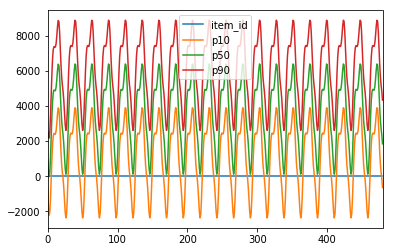

In [34]:
arima_predicts.plot()

In [35]:
# Convert the column to datetime
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

In [36]:
arima_predicts.sample()

,item_id,date,p10,p50,p90
223,1,2018-01-10 07:00:00+00:00,1845.575223,4339.630835,6833.686447


In [37]:
# Remove the timezone and make date the index
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

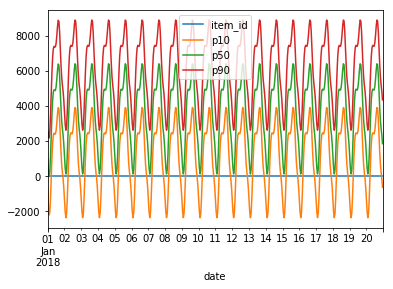

In [38]:
arima_predicts.plot()

In [39]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2018-01-01 00:00:00
2018-01-20 23:00:00


Here we can see our prediction goes from Jan 01 to Jan 20 as expected, given our 480 interval forecast horizon. Also, we can see the cyclical nature of the predictions over the entire timeframe. 

Now we are going to create a data frame of the prediction values from this Forecast and the actual values.

First, let us remove the column ID of the item before continuing.

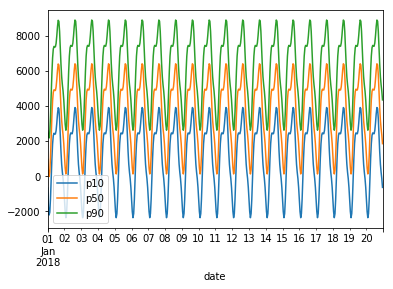

In [40]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

2018-01-01 00:00:00
2018-01-20 23:00:00


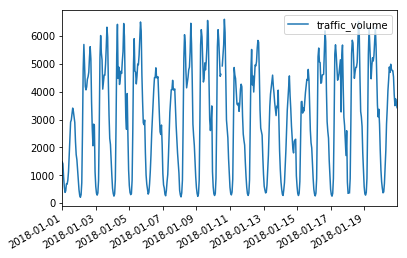

In [41]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-20']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [42]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

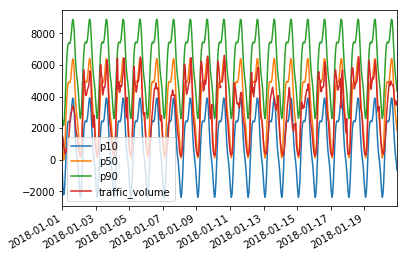

In [43]:
# Plot
arima_val_df.plot()

Given that this particular plot is hard to see, let us pick a random day January 5th to compare.

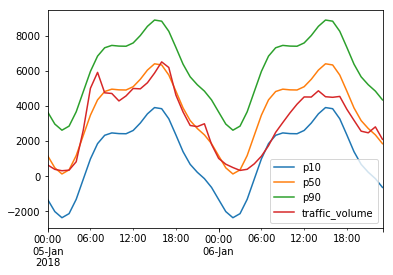

In [44]:
arima_val_df_jan_5 = arima_val_df.loc['2018-01-05':'2018-01-06']
arima_val_df_jan_5.plot()

We have here the good match between predicted and actual value.

Now this is pretty clear for p50 showcasing that it does a great job of predicting the volume. Let us now do this for Prophet and DeepAR+.

### Prophet Validation

We will speed up the prep work to just a few cells this time.

In [45]:
# Prophet Eval
prophet_predicts = pd.read_csv(data_dir+"/"+prophet_filename)
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

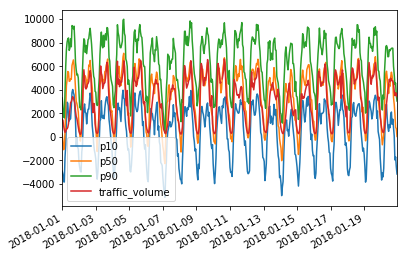

In [46]:
# Plot
prophet_val_df.plot()

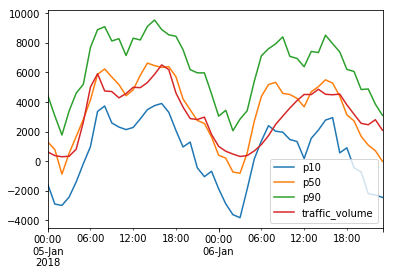

In [47]:
prophet_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_val_df_jan_5.plot()

### DeepAR+ Validation

In [48]:
# DeepAR+ Eval
deeparp_predicts = pd.read_csv(data_dir+"/"+deeparp_filename)
deeparp_predicts.sample()
# Remove the timezone
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date'])
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None)
deeparp_predicts.set_index('date', inplace=True)
deeparp_predicts = deeparp_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
deeparp_val_df = deeparp_predicts.join(validation_df, how='outer')

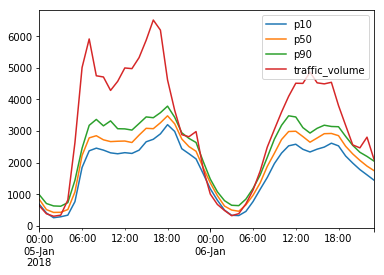

In [49]:
deeparp_val_df_jan_5 = deeparp_val_df.loc['2018-01-05':'2018-01-06']
deeparp_val_df_jan_5.plot()

What is particularly interesting here is that we were below the actual numbers for a good portion of the day, even with p90. We did see an excellent performance from Prophet, and the metrics indicate that DeepAR+ is objectively better here, so now we will add related time-series data to our project and see how the models behave then.

----

## Recap and Next Steps

At this point, we can now see through the 3 plots below that DeepAR+ does an excellent job outside of the high ranges, and that perhaps adding related data could improve both Prophet and DeepAR+'s performance. The next thing to do is to move to the notebook for importing your related-time series data and then progress to the second Creating and Evaluating notebook that will explain how to leverage the related data.

In [51]:
%store prophet_summary_metrics
%store deeparp_summary_metrics

Stored 'prophet_summary_metrics' (dict)
Stored 'deeparp_summary_metrics' (dict)
